In [2]:
library(tidyverse)
library(readr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
data <- read_csv("../input/brics-dataset/Russia.csv")

Rows: 353 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): CCUSMA02RUM618N
date (1): DATE


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
typeof(data)

[1] "list"

In [5]:
spec(data)

cols(
  DATE = col_date(format = ""),
  CCUSMA02RUM618N = col_double()
)

In [6]:
del_data = data[data$DATE <= as.Date("1999-12-31", "%Y-%m-%d"), ] 
data = data[data$DATE > as.Date("1999-12-31", "%Y-%m-%d"), ]

In [7]:
head(data,5)

DATE,CCUSMA02RUM618N
<date>,<dbl>
2000-01-01,28.1891
2000-02-01,28.7276
2000-03-01,28.4581
2000-04-01,28.5924
2000-05-01,28.3108


In [8]:
data = data[data$CCUSMA02RUM618N != '.', ]

In [9]:
lengths(data)

DATE CCUSMA02RUM618N 
            262             262

In [10]:
date1 = as.Date("1999-12-31", "%Y-%m-%d")
date2 = data$DATE[length(data$DATE)]     #lengthof data is 5482

In [11]:
length = date2 - date1 
length

Time difference of 7945 days

In [12]:
lst_val = 1:length(data$DATE)
lst_val <- as.double(lst_val)

In [13]:
check_date = as.Date("2000-01-01", "%Y-%m-%d")
start_val = del_data$CCUSMA02RUM618N[length(del_data$DATE)]

In [14]:
lst_val

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
[217] 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
[235] 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
[253] 253 254 255 256 257 258 259 260 261 262

In [15]:
idx = 3
for (i in 1:length(data$DATE)){    
    lst_val[i] <- as.numeric(data$CCUSMA02RUM618N[i])
    check_date <- check_date + 1
}

In [16]:
lst_val

[1] 28.18910 28.72760 28.45810 28.59240 28.31080 28.24320 27.84960 27.73560
  [9] 27.79810 27.87000 27.80920 27.96630 28.35920 28.59420 28.67690 28.84640
 [17] 29.01830 29.11440 29.21730 29.34520 29.42880 29.53440 29.79560 30.09160
 [25] 30.46690 30.80070 31.05900 31.17170 31.24760 31.40210 31.51440 31.55630
 [33] 31.62510 31.69260 31.80830 31.83710 31.81520 31.70180 31.45380 31.21220
 [41] 30.91940 30.48130 30.35970 30.34780 30.59530 30.16490 29.81380 29.43910
 [49] 28.92340 28.51540 28.53340 28.67590 28.98670 29.03150 29.08170 29.21300
 [57] 29.22180 29.07760 28.58440 27.92010 27.93500 27.97360 27.61600 27.82050
 [65] 27.92030 28.50420 28.68880 28.47560 28.36450 28.54720 28.75650 28.81110
 [73] 28.41220 28.19680 27.87770 27.57240 27.05780 26.98390 26.91500 26.76530
 [81] 26.74420 26.85580 26.62390 26.28650 26.47490 26.33510 26.11080 25.84200
 [89] 25.81830 25.92560 25.55640 25.63050 25.34305 24.89390 24.47368 24.56591
 [97] 24.50110 24.53470 23.76070 23.51270 23.72940 23.63760 23.35050 24.13140
[105] 25.28370 26.35120 27.31010 28.13140 31.47150 35.75970 34.66650 33.55540
[113] 32.05760 31.02620 31.51520 31.62750 30.81140 29.47480 28.98310 29.93540
[121] 29.94370 30.18840 29.56440 29.19800 30.35120 31.16738 30.68470 30.34211
[129] 30.83597 30.31977 30.96720 30.85216 30.08430 29.29420 28.43080 28.10397
[137] 27.86956 27.98406 27.89988 28.76730 30.49050 31.35119 30.85970 31.45264
[145] 31.50951 29.88196 29.39580 26.42656 30.64820 32.91320 32.50000 32.03300
[153] 31.52729 31.09204 31.41008 30.74035 30.25781 30.16084 30.79837 31.32901
[161] 31.24061 32.27776 32.73641 33.01543 32.62843 32.06225 32.64480 32.89400
[169] 33.45700 35.22370 36.21100 35.66180 34.92690 34.40650 34.63520 36.10997
[177] 37.86952 40.75890 45.86490 55.41310 61.69876 64.63237 60.23427 52.86940
[185] 50.58070 54.49980 57.06730 65.15150 66.76620 63.06520 65.02600 69.66030
[193] 76.25060 77.21740 70.47110 66.68270 65.66300 65.30600 64.33400 64.92310
[201] 64.59760 62.67980 64.36120 62.18470 59.95580 58.39210 58.10370 56.43000
[209] 57.17000 57.81850 59.66838 59.64681 57.69390 57.72985 58.91817 58.58640
[217] 56.78430 56.80760 57.03310 60.42680 62.20620 62.71150 62.88150 66.09440
[225] 67.64670 65.88530 66.23750 67.30270 67.33280 65.85930 65.14290 64.61700
[233] 64.81520 64.22460 63.19830 65.52780 64.97950 64.35390 63.86500 62.93560
[241] 61.78080 63.87760 73.14800 75.21690 72.61100 69.22170 71.28250 73.79700
[249] 75.65130 77.58870 77.03300 74.05040 74.22470 74.37940 74.40930 76.09240
[257] 74.04200 72.50830 73.91740 73.59290 72.89100 71.49200

In [17]:
print("Enter 0 if you want the test data to start from 2020 and 1 if you want the test data to start from 2021")
offset = readline()
offset = as.integer(offset)

[1] "Enter 0 if you want the test data to start from 2020 and 1 if you want the test data to start from 2021"


 1


In [18]:
test_date = as.Date("2021-01-01", "%Y-%m-%d")
if(offset == 0){
    test_date = as.Date("2020-01-01", "%Y-%m-%d")
}

In [19]:
train = lst_val[1: as.numeric(((test_date - date1)/365)*12)]

In [20]:
test = lst_val[as.numeric(((test_date - date1)/365)*12) : length(lst_val)]

In [21]:
length(train)
length(test)

[1] 252

[1] 10

In [22]:
train_dates = seq(as.Date("2000-01-01"), as.Date("2020-12-01"), by="month")
test_dates = seq(as.Date("2021-01-01"), as.Date("2021-10-01"), by="months")

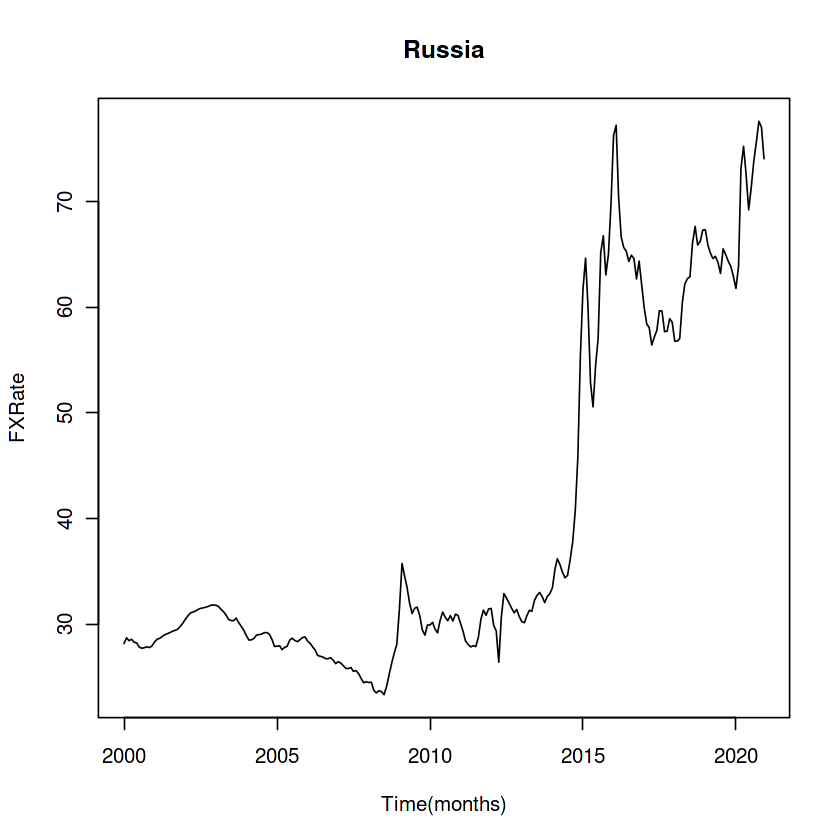

In [23]:
plot(train_dates,train,type="l",xlab="Time(months)",ylab="FXRate",main="Russia")

In [24]:
train <- ts(as.numeric(train))
test <- ts(as.numeric(test), start = length(train)+1,
           end = (length(train) + length(test)))
#converting to time series

In [25]:
test
train

A Time Series:
 [1] 74.0504 74.2247 74.3794 74.4093 76.0924 74.0420 72.5083 73.9174 73.5929
[10] 72.8910

A Time Series:
  [1] 28.18910 28.72760 28.45810 28.59240 28.31080 28.24320 27.84960 27.73560
  [9] 27.79810 27.87000 27.80920 27.96630 28.35920 28.59420 28.67690 28.84640
 [17] 29.01830 29.11440 29.21730 29.34520 29.42880 29.53440 29.79560 30.09160
 [25] 30.46690 30.80070 31.05900 31.17170 31.24760 31.40210 31.51440 31.55630
 [33] 31.62510 31.69260 31.80830 31.83710 31.81520 31.70180 31.45380 31.21220
 [41] 30.91940 30.48130 30.35970 30.34780 30.59530 30.16490 29.81380 29.43910
 [49] 28.92340 28.51540 28.53340 28.67590 28.98670 29.03150 29.08170 29.21300
 [57] 29.22180 29.07760 28.58440 27.92010 27.93500 27.97360 27.61600 27.82050
 [65] 27.92030 28.50420 28.68880 28.47560 28.36450 28.54720 28.75650 28.81110
 [73] 28.41220 28.19680 27.87770 27.57240 27.05780 26.98390 26.91500 26.76530
 [81] 26.74420 26.85580 26.62390 26.28650 26.47490 26.33510 26.11080 25.84200
 [89] 25.81830 25.92560 25.55640 25.63050 25.34305 24.89390 24.47368 24.56591
 [97] 24.50110 24.53470 23.76070 23.51270 23.72940 23.63760 23.35050 24.13140
[105] 25.28370 26.35120 27.31010 28.13140 31.47150 35.75970 34.66650 33.55540
[113] 32.05760 31.02620 31.51520 31.62750 30.81140 29.47480 28.98310 29.93540
[121] 29.94370 30.18840 29.56440 29.19800 30.35120 31.16738 30.68470 30.34211
[129] 30.83597 30.31977 30.96720 30.85216 30.08430 29.29420 28.43080 28.10397
[137] 27.86956 27.98406 27.89988 28.76730 30.49050 31.35119 30.85970 31.45264
[145] 31.50951 29.88196 29.39580 26.42656 30.64820 32.91320 32.50000 32.03300
[153] 31.52729 31.09204 31.41008 30.74035 30.25781 30.16084 30.79837 31.32901
[161] 31.24061 32.27776 32.73641 33.01543 32.62843 32.06225 32.64480 32.89400
[169] 33.45700 35.22370 36.21100 35.66180 34.92690 34.40650 34.63520 36.10997
[177] 37.86952 40.75890 45.86490 55.41310 61.69876 64.63237 60.23427 52.86940
[185] 50.58070 54.49980 57.06730 65.15150 66.76620 63.06520 65.02600 69.66030
[193] 76.25060 77.21740 70.47110 66.68270 65.66300 65.30600 64.33400 64.92310
[201] 64.59760 62.67980 64.36120 62.18470 59.95580 58.39210 58.10370 56.43000
[209] 57.17000 57.81850 59.66838 59.64681 57.69390 57.72985 58.91817 58.58640
[217] 56.78430 56.80760 57.03310 60.42680 62.20620 62.71150 62.88150 66.09440
[225] 67.64670 65.88530 66.23750 67.30270 67.33280 65.85930 65.14290 64.61700
[233] 64.81520 64.22460 63.19830 65.52780 64.97950 64.35390 63.86500 62.93560
[241] 61.78080 63.87760 73.14800 75.21690 72.61100 69.22170 71.28250 73.79700
[249] 75.65130 77.58870 77.03300 74.05040

In [26]:
install.packages("WaveletArima")
library(WaveletArima)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [27]:
library(tseries)
library(forecast)
library(Metrics)
library(ggplot2)
library(readr)
# library(WaveletArima)
library(caret)
library(nnfor)
library(tsDyn)
library(fracdiff)
library(bsts)
library(forecastHybrid)
library(e1071)
library(tseriesChaos)
library(pracma)
library(Kendall)
# library(nonlinearTseries)
# library(GeneCycle)
library(fpp2)
library(lmtest)


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:Metrics’:

    precision, recall


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Registered S3 method overwritten by 'greybox':
  method     from
  print.pcor lava


Attaching package: ‘tsDyn’


The following object is masked from ‘package:Metrics’:

    mse


Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots


Loading required package: zoo


A

In [28]:
# autoplot(train)

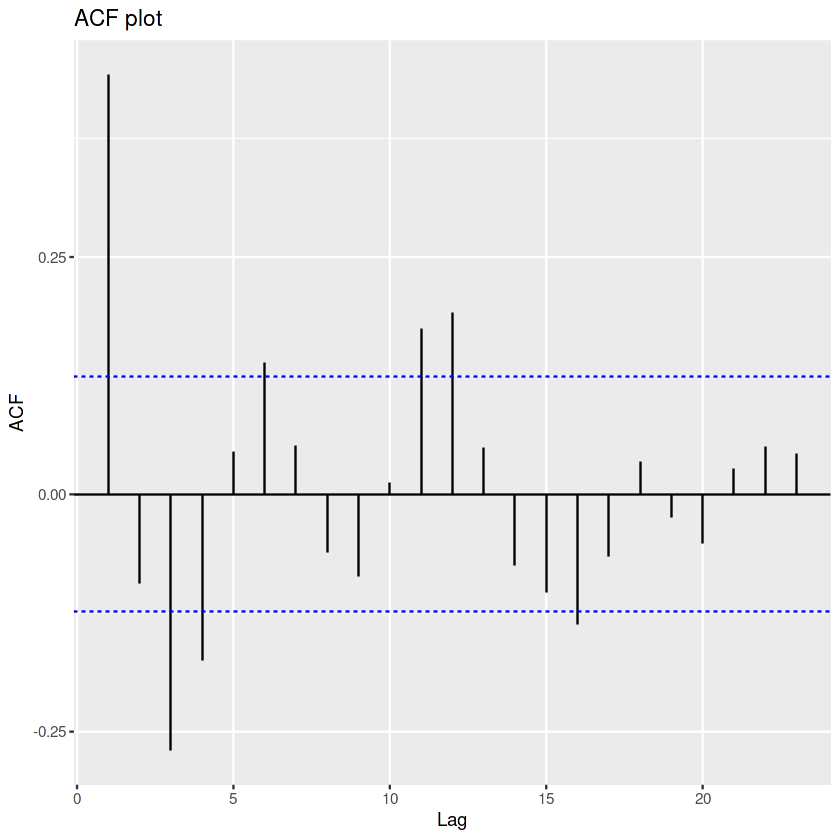

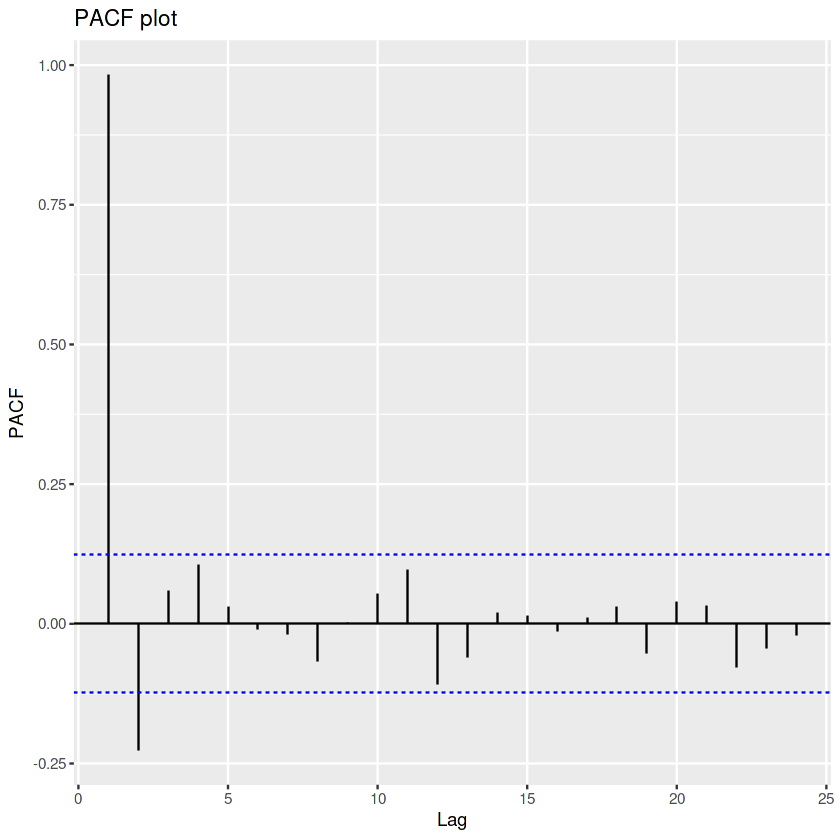

In [29]:
#ACF & PACF plots
#diffcase=ndiffs(train)
diffset = diff(train, differences = ndiffs(train))
ggAcf(diffset) +
  ggtitle("ACF plot")

ggPacf(train) +
  ggtitle("PACF plot")


In [30]:
kpss.test(train)  #p value is < 0.05... So,reject null hypothesis and accept alternative hypothisis which is non stationary 

Warning message in kpss.test(train):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  train
KPSS Level = 3.1543, Truncation lag parameter = 5, p-value = 0.01


In [31]:
Box.test(train,type="Ljung-Box")  #p<0.01... So, no seriel correlation exists


	Box-Ljung test

data:  train
X-squared = 246.86, df = 1, p-value < 2.2e-16


In [32]:
skewness(train)   #Right Skew

[1] 0.9783259

In [33]:
kurtosis(train)   #Peaked distribution

[1] -0.7437095

In [34]:
hurstexp(train)  #Which exponent to consider  #Emperical

Simple R/S Hurst estimation:         0.8513473 
Corrected R over S Hurst exponent:   1.037038 
Empirical Hurst exponent:            1.114522 
Corrected empirical Hurst exponent:  1.079894 
Theoretical Hurst exponent:          0.5519114 


In [35]:
terasvirta.test(train) 
#Also a test for linearity... p-value is greater than 0.05, hence linear trend


	Teraesvirta Neural Network Test

data:  train
X-squared = 13.517, df = 2, p-value = 0.001161


In [36]:
#Non-Chaotic
max_lyapunov_expo <-lyap_k(train, m=1, d=2, s=1, t=4, ref=length(train), k=2, eps=4); max_lyapunov_expo

Finding nearests
Keeping  249  reference points
Following points


A Time Series:
[1] -2.482271

# **Models**


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1  0.615393   0.059125  10.408 < 2.2e-16 ***
ar2 -0.359291   0.058978  -6.092 1.115e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Series: train 
ARIMA(2,1,0) 

Coefficients:
         ar1      ar2
      0.6154  -0.3593
s.e.  0.0591   0.0590

sigma^2 estimated as 2.281:  log likelihood=-458.89
AIC=923.79   AICc=923.88   BIC=934.36

Training set error measures:
                    ME    RMSE       MAE       MPE     MAPE      MASE
Training set 0.1333793 1.50129 0.8496063 0.2507633 1.889317 0.8555294
                   ACF1
Training set -0.0316001

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1333793,1.501290,0.8496063,0.2507633,1.889317,0.8555294,-0.0316001,NA
Test set,0.8741353,1.298846,1.1053117,1.1664335,1.484670,1.1130174,0.2502812,1.090171


[1] 0.01498528

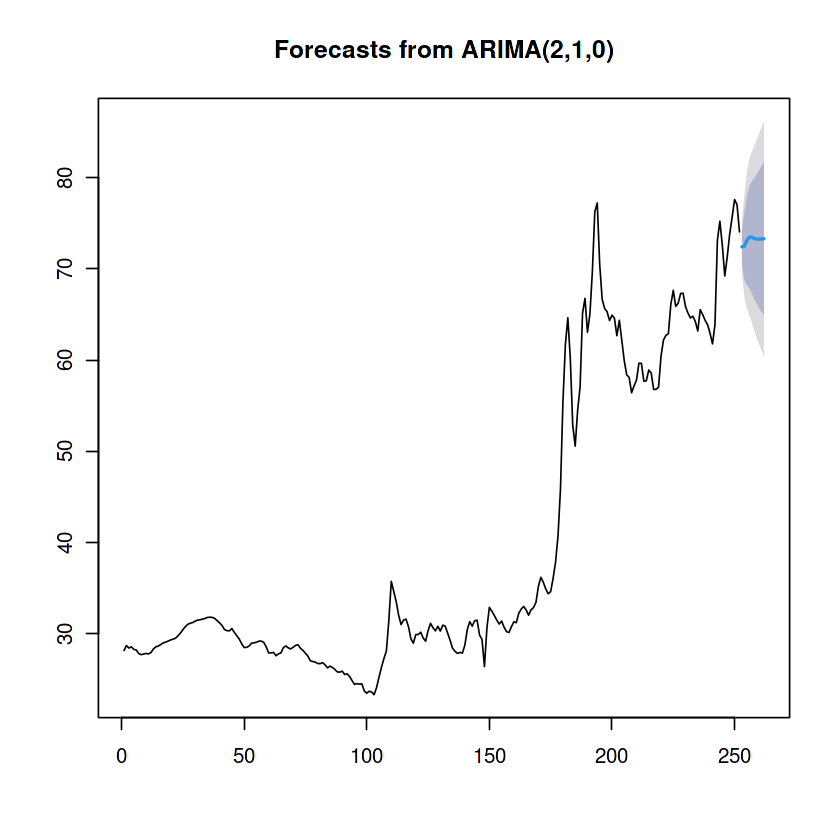

In [37]:
#ARIMA - Classical
fitARIMA = auto.arima(train)
coeftest(fitARIMA)
summary(fitARIMA)
predARIMA = forecast::forecast(fitARIMA,h=length(test))
plot(predARIMA)

a1<-forecast::accuracy(predARIMA, test);a1
smape(test,predARIMA$mean)

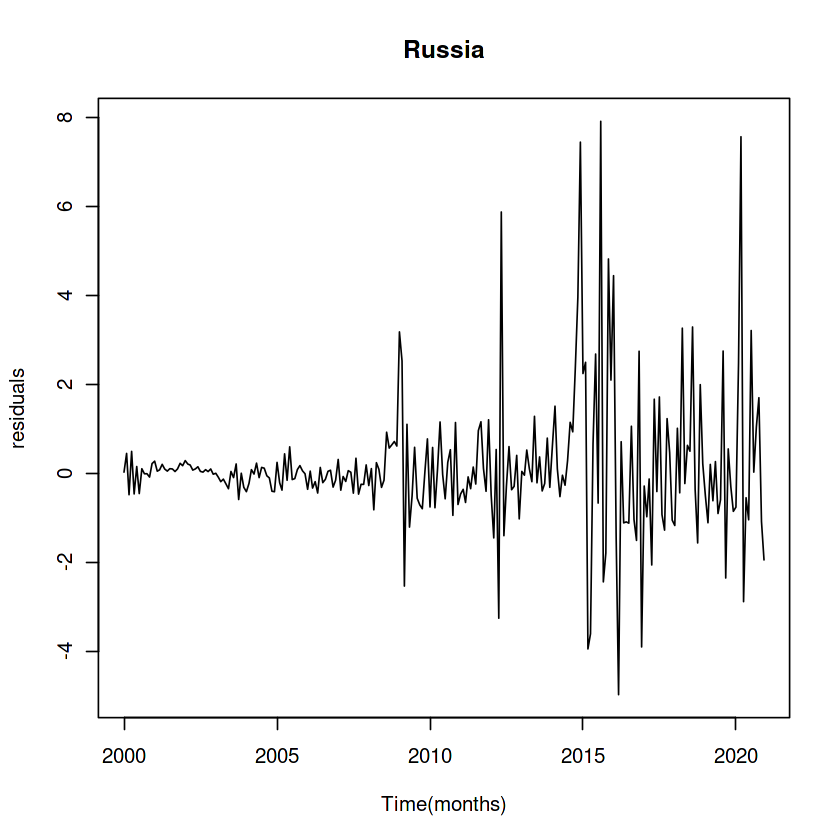

In [38]:
plot(train_dates,fitARIMA$residuals,type="l",xlab="Time(months)",ylab="residuals",main="Russia")

In [39]:
library(stringi)
lag = stri_count(toString(summary(fitARIMA)[1]), fixed="ar")

ETS(M,Ad,N) 

Call:
 ets(y = train) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.621 
    phi   = 0.8 

  Initial states:
    l = 28.3319 
    b = 0.1383 

  sigma:  0.0353

     AIC     AICc      BIC 
1532.143 1532.485 1553.319 

Training set error measures:
                     ME     RMSE       MAE       MPE     MAPE     MASE
Training set 0.04324337 1.748701 0.9609477 0.1126644 2.064291 0.967647
                  ACF1
Training set 0.1933511

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.04324337,1.748701,0.9609477,0.1126644,2.064291,0.967647,0.1933511,NA
Test set,4.58846037,4.835061,4.5884604,6.1948629,6.194863,4.620449,0.4391088,4.415668


[1] 0.06415406

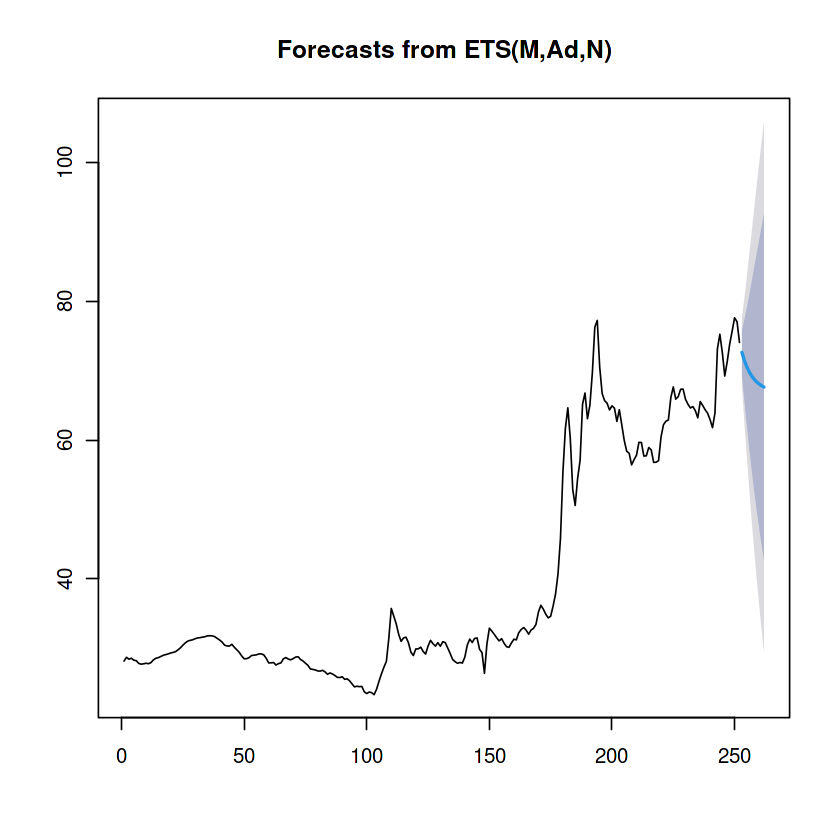

In [40]:
# fitting ETS  -- Smoothing Basic
fitETS=ets(train)
summary(fitETS)
predETS=forecast::forecast(fitETS, h=length(test))
plot(predETS)

a2<-forecast::accuracy(predETS, test);a2
smape(test,predETS$mean)

Warning message:
“Possible unit root in the high  regime. Roots are: 0.9593 1.3194 1.3194 4.1304”
Warning message:
“Possible unit root in the low  regime. Roots are: 0.9426 2.0556 2.0556 94.6898”


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.2206743,1.065923,0.9316213,-0.311457,1.261338,0.2069368,0.895139


[1] 0.01258785

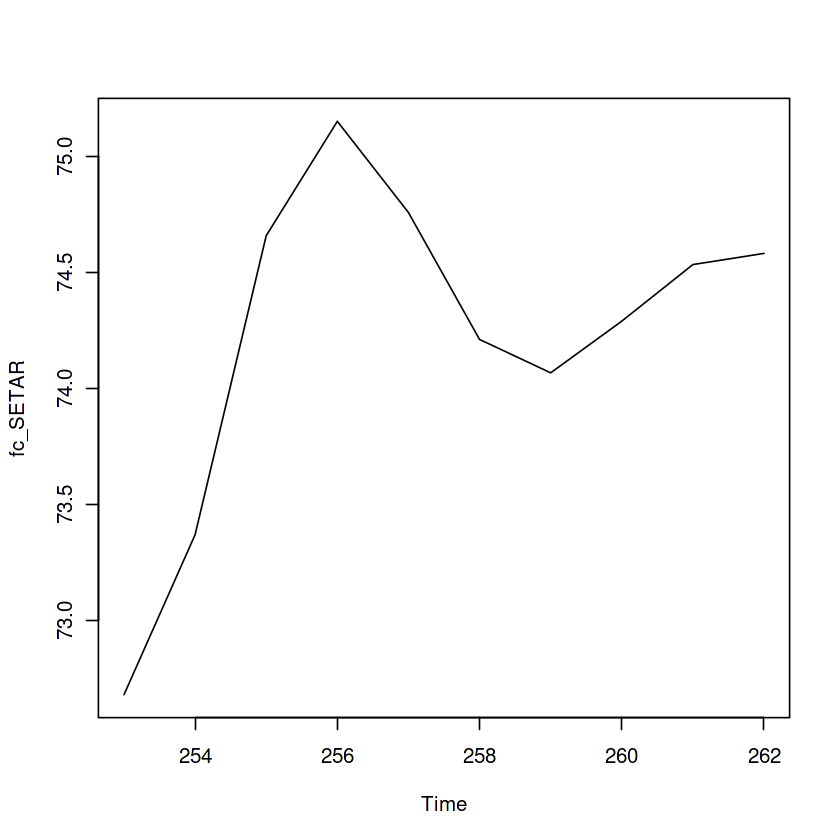

In [41]:
#SETAR - Classical
fit_SETAR = setar(train, m=4)
fc_SETAR = predict(fit_SETAR, n.ahead = length(test))
plot(fc_SETAR)

a3<-forecast::accuracy(fc_SETAR, test);a3
smape(test, fc_SETAR)

                  Length Class  Mode     
lambda              1    -none- numeric  
alpha               1    -none- numeric  
beta                0    -none- NULL     
damping.parameter   0    -none- NULL     
gamma.values        0    -none- NULL     
ar.coefficients     0    -none- NULL     
ma.coefficients     0    -none- NULL     
likelihood          1    -none- numeric  
optim.return.code   1    -none- numeric  
variance            1    -none- numeric  
AIC                 1    -none- numeric  
parameters          2    -none- list     
seed.states         1    -none- numeric  
fitted.values     252    ts     numeric  
errors            252    ts     numeric  
x                 252    -none- numeric  
seasonal.periods    0    -none- NULL     
y                 252    ts     numeric  
call                2    -none- call     
series              1    -none- character
method              1    -none- character

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1077717,1.550805,0.8543076,0.202118,1.878884,0.8602634,0.1078201,NA
Test set,1.0947070,1.426698,1.1812762,1.464158,1.583514,1.1895115,0.2065667,1.262453


[1] 0.01601506

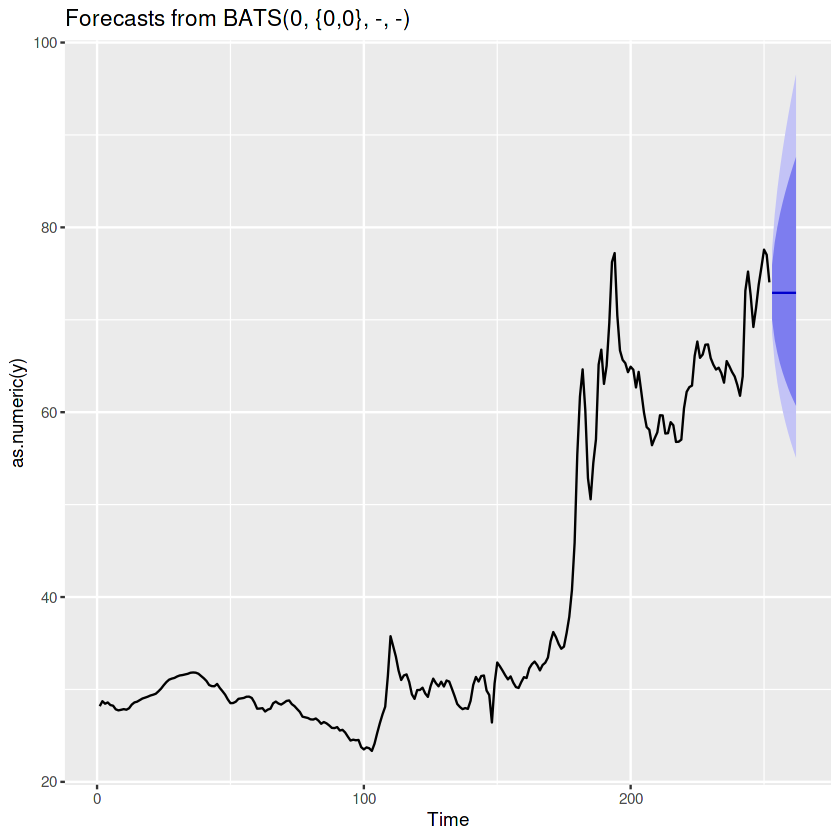

In [42]:
#TBATS - Smotthing
fit_tbats = tbats(train)
summary(fit_tbats)
predTBATS=forecast::forecast(fit_tbats, h=length(test))
autoplot(predTBATS)

a4<-forecast::accuracy(predTBATS, test);a4
smape(test,predTBATS$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.5367185,1.190612,0.8662745,-0.7425549,1.176004,0.343101,1.094445


[1] 0.01167405

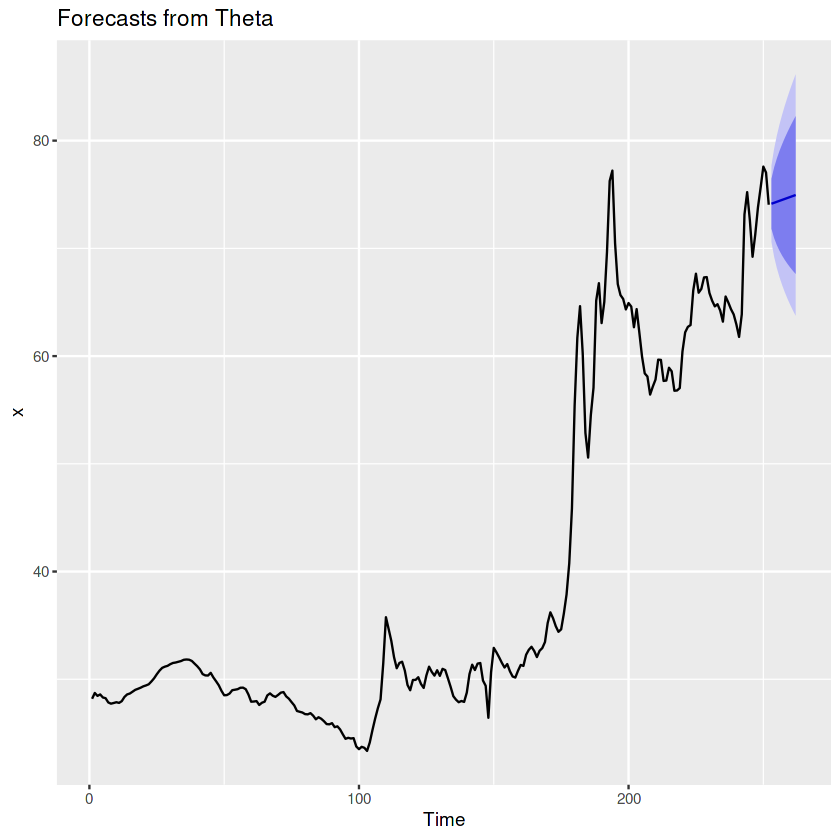

In [43]:
#Theta -- Smotthing
fit_theta=thetaf(train, h=length(test))
autoplot(fit_theta)

a5<-forecast::accuracy(fit_theta$mean, test);a5
smape(test,fit_theta$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,8.629755,8.966966,8.629755,11.66176,11.66176,0.5144074,8.178236


[1] 0.124475

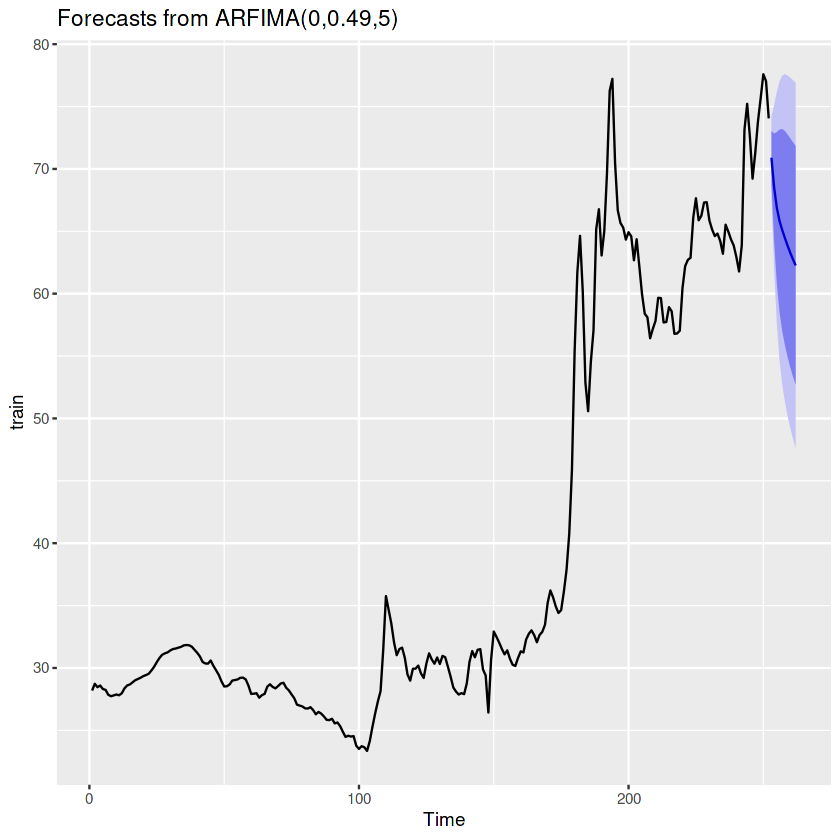

In [44]:
#ARFIMA model -- Classical
fit_ARFIMA=arfima(train)
predARFIMA = forecast::forecast(fit_ARFIMA, h=length(test))
autoplot(predARFIMA)

a6<-forecast::accuracy(predARFIMA$mean, test);a6
smape(test,predARFIMA$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-2.327782,2.613815,2.327782,-3.161601,3.161601,0.373934,2.39549


[1] 0.0309954

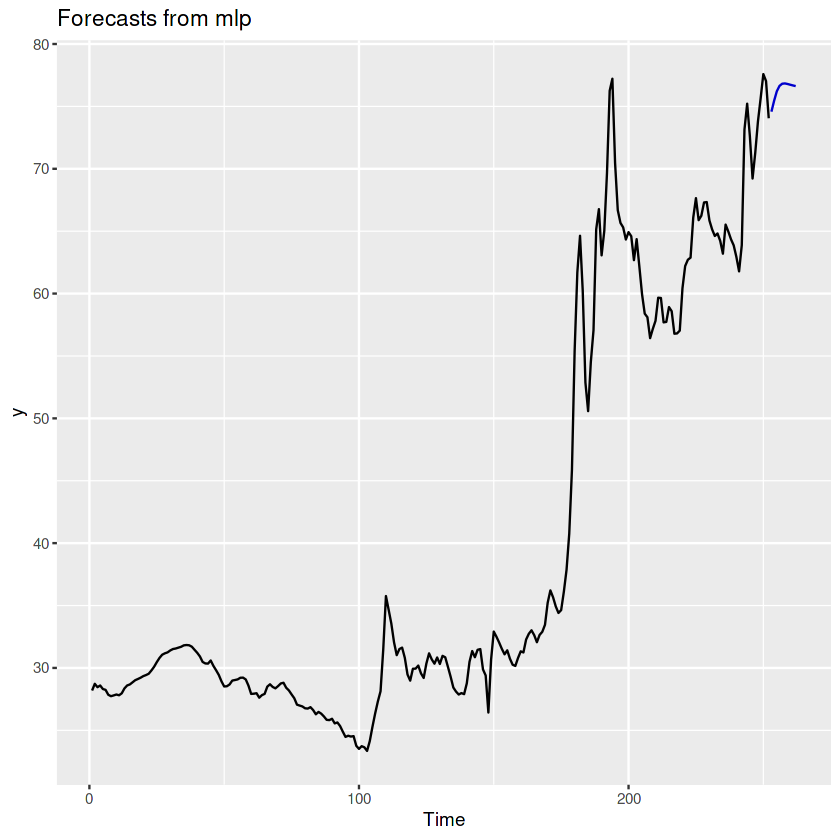

In [45]:
#fitting ANN -- ML Model
fit_ANN = mlp(train)
predANN = forecast::forecast(fit_ANN, h=length(test))
autoplot(predANN)

a7<-forecast::accuracy(predANN$mean, test);a7
smape(test,predANN$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,6.753129,7.007161,6.753129,9.119407,9.119407,0.4538386,6.383564


[1] 0.09590335

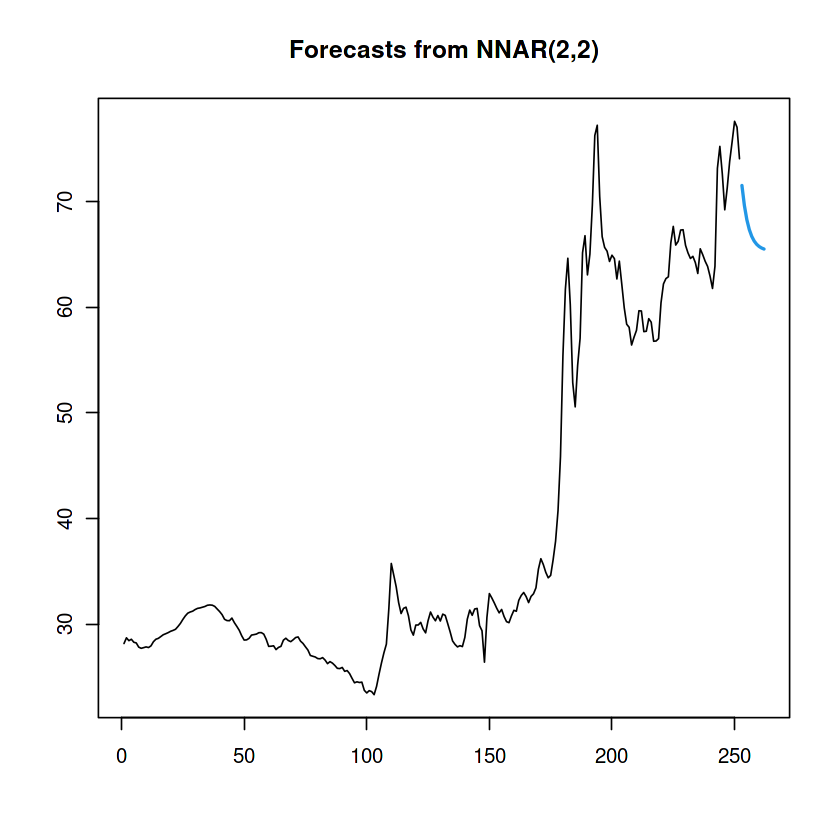

In [46]:
#fitting ARNN model -- ML Model
fit_ARNN = nnetar(train)
predARNN=forecast::forecast(fit_ARNN, h= length(test))
plot(predARNN)

a8<-forecast::accuracy(predARNN$mean, test);a8
smape(test, predARNN$mean)

Warning message in preprocess(y, m, lags, keep, difforder, sel.lag, allow.det.season, :
“No inputs left in the network after pre-selection, forcing AR(1).”


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.7346699,1.204872,1.018606,0.9779719,1.368781,0.2465348,1.022521


[1] 0.01379864

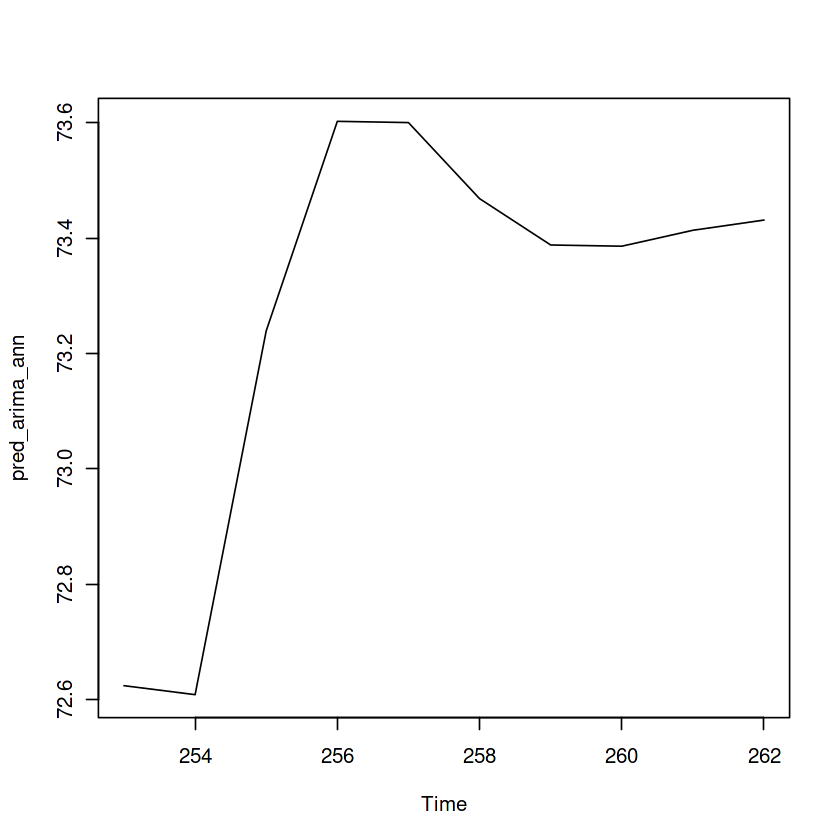

In [47]:
#fitting ARIMA + ANN hyybrid
fit_res_ANN=mlp(fitARIMA$residuals)
pred_res_ANN = forecast::forecast(fit_res_ANN, h=length(test))
pred_arima_ann=predARIMA$mean+pred_res_ANN$mean
plot(pred_arima_ann)

a9<-forecast::accuracy(pred_arima_ann, test);a9
smape(test,pred_arima_ann)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.7220979,1.198858,1.012184,0.9609806,1.360249,0.2479461,1.014827


[1] 0.0137112

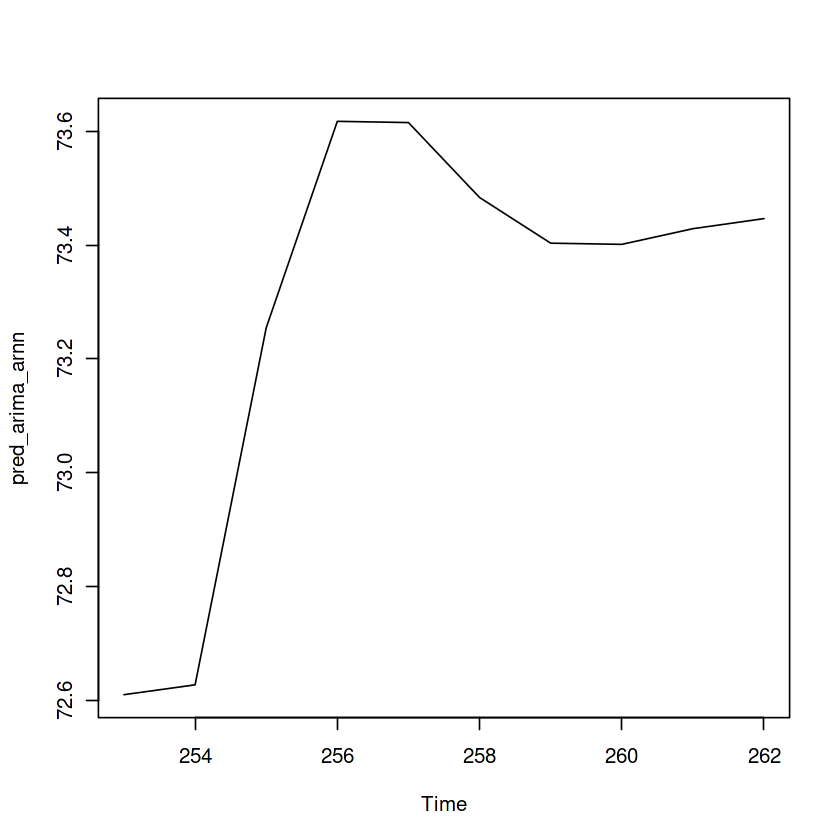

In [48]:
#fitting ARIMA + ARNN hybrid
fit_res_ARNN=nnetar(fitARIMA$residuals)
pred_res_ARNN = forecast::forecast(fit_res_ARNN, h=length(test))
pred_arima_arnn=predARIMA$mean+pred_res_ARNN$mean
plot(pred_arima_arnn)

a10<-forecast::accuracy(pred_arima_arnn, test);a10
smape(test,pred_arima_arnn)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,1.714328,1.903362,1.714328,2.304041,2.304041,0.05561796,1.714705


[1] 0.02336953

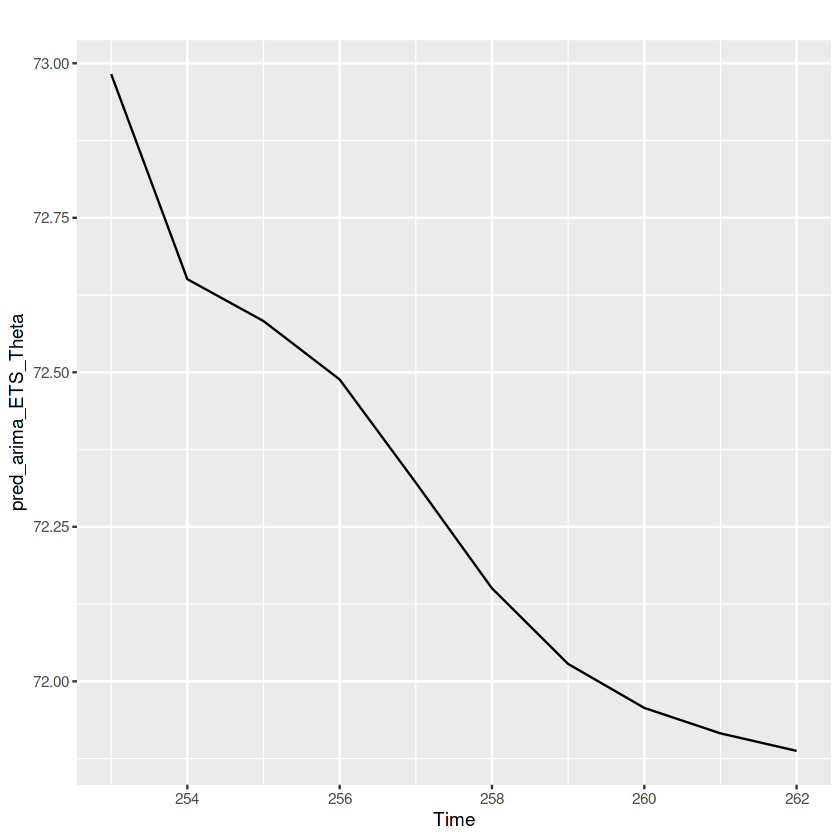

In [49]:
#ARIMA+ETS+THETA
pred_arima_ETS_Theta = ((0.333*predARIMA$mean) + (0.333*predETS$mean) + (0.333*fit_theta$mean))
autoplot(pred_arima_ETS_Theta)

a11<-forecast::accuracy(pred_arima_ETS_Theta, test);a11
smape(test,pred_arima_ETS_Theta)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,4.141847,4.294794,4.141847,5.588074,5.588074,0.2737183,3.897015


[1] 0.05760741

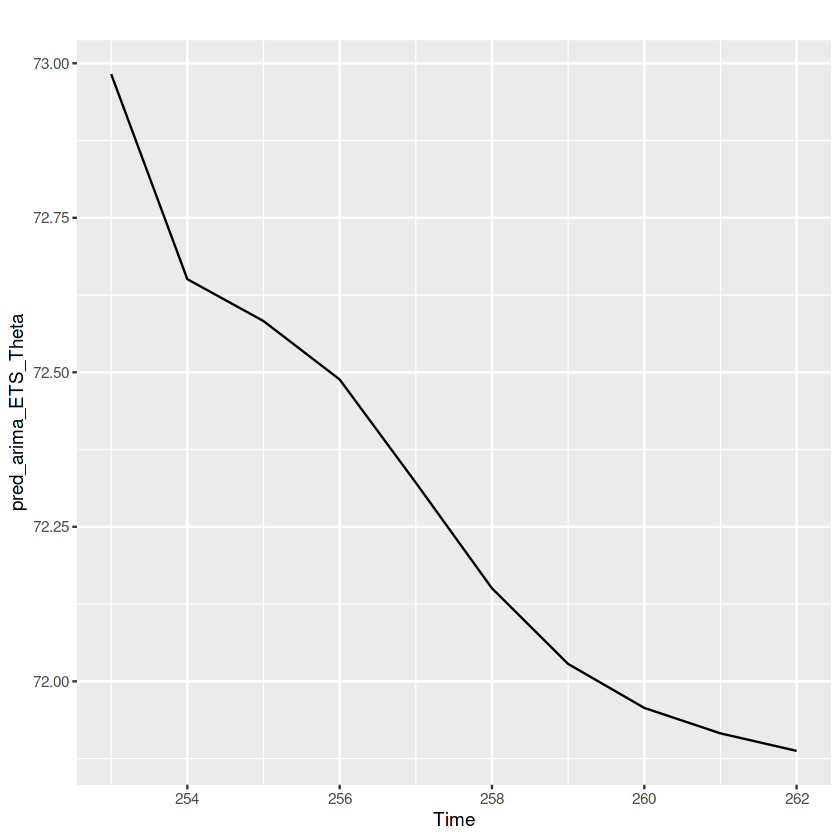

In [50]:
#ARIMA+ETS+ARNN
pred_arima_ETS_ARNN = ((0.333*predARIMA$mean) + (0.333*predETS$mean) + (0.333*predARNN$mean))
autoplot(pred_arima_ETS_Theta)

a12<-forecast::accuracy(pred_arima_ETS_ARNN, test);a12
smape(test,pred_arima_ETS_ARNN)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,2.435163,2.592503,2.435163,3.277914,3.277914,0.1095921,2.337313


[1] 0.03339552

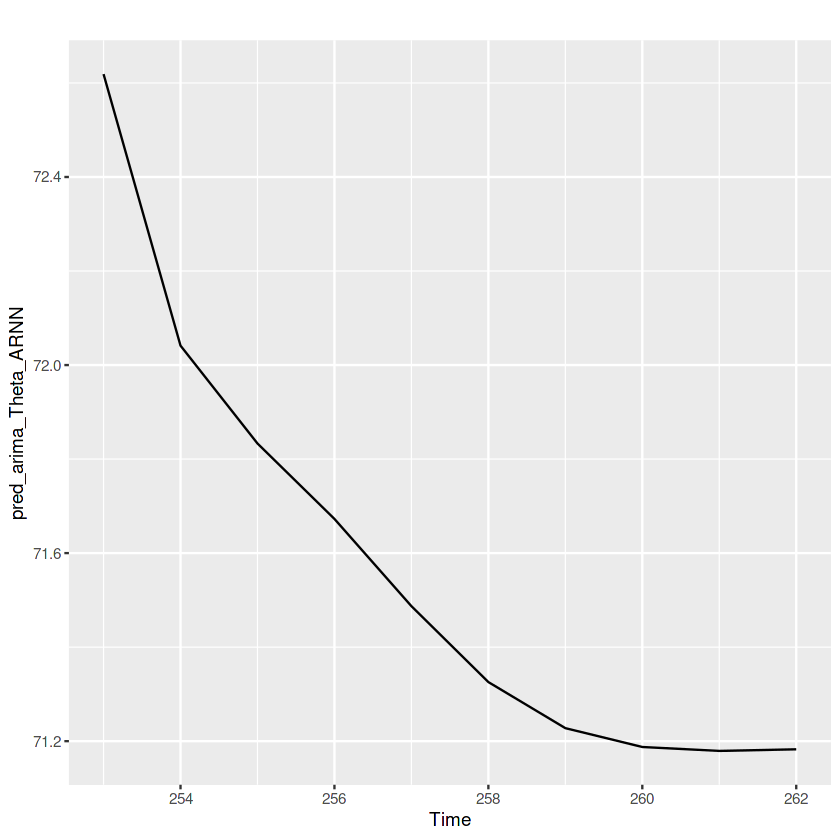

In [51]:
#ARIMA+theta+ARNN
pred_arima_Theta_ARNN = ((0.333*predARIMA$mean) + (0.333*fit_theta$mean) + (0.333*predARNN$mean))
autoplot(pred_arima_Theta_ARNN)

a13<-forecast::accuracy(pred_arima_Theta_ARNN, test);a13
smape(test,pred_arima_Theta_ARNN)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,3.672033,3.860147,3.672033,4.952381,4.952381,0.3013487,3.515791


[1] 0.05091278

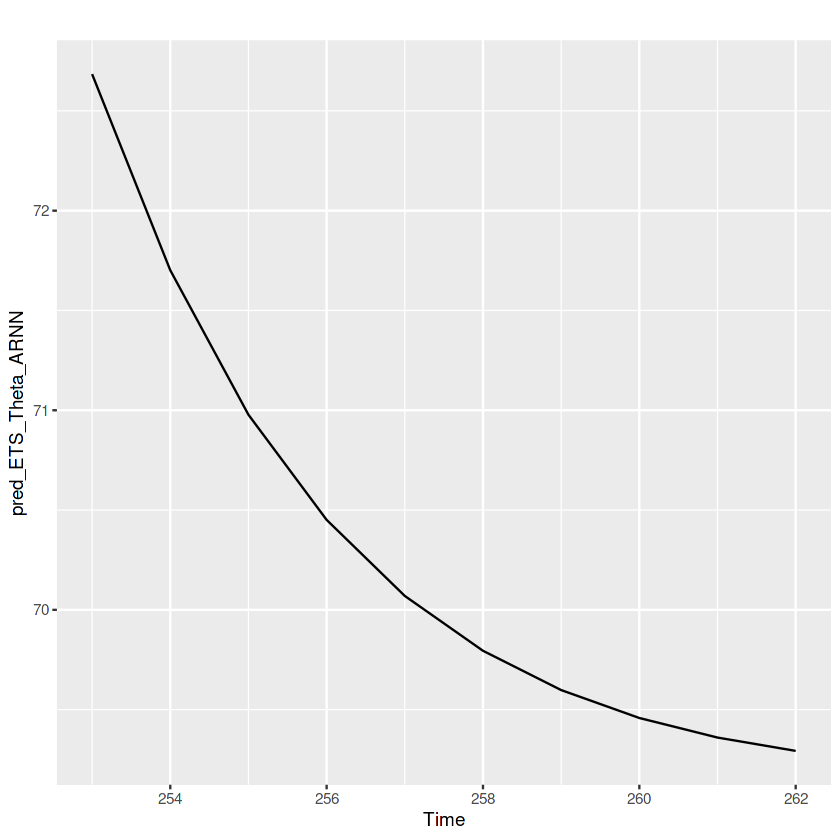

In [52]:
#ETS+theta+ARNN
pred_ETS_Theta_ARNN = ((0.333*predETS$mean) + (0.333*fit_theta$mean) + (0.333*predARNN$mean))
autoplot(pred_ETS_Theta_ARNN)

a14<-forecast::accuracy(pred_ETS_Theta_ARNN, test);a14
smape(test,pred_ETS_Theta_ARNN)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-1.116306,2.117264,1.833226,-1.524624,2.480203,0.2361794,1.927978


[1] 0.02448138

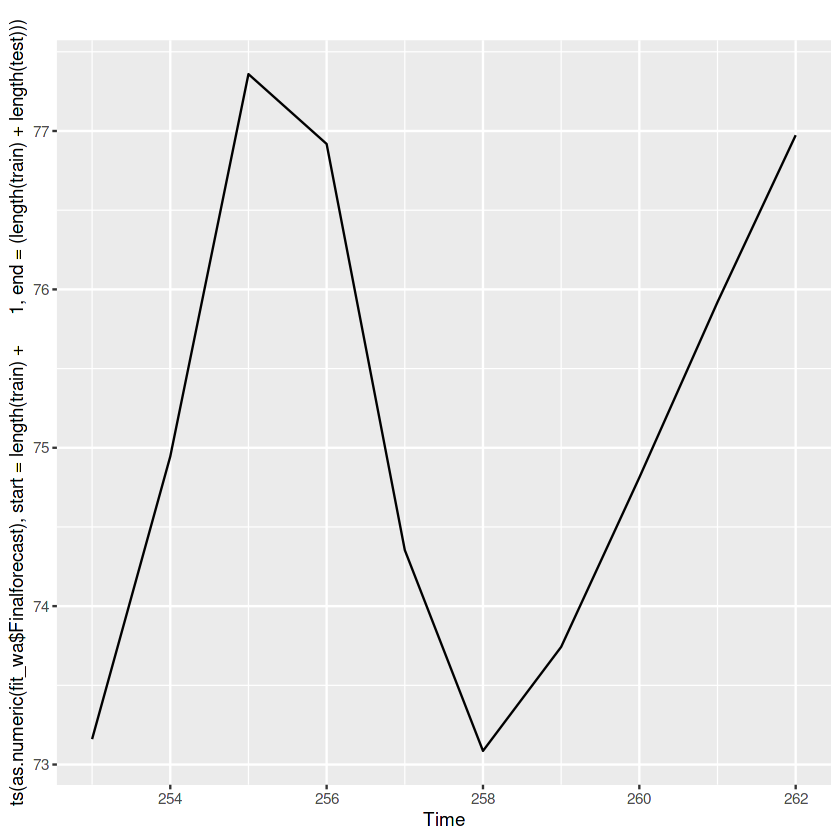

In [53]:
#WaveletArima -- Advanced
fit_wa <- WaveletFittingarma(train, Waveletlevels = floor(log(length(train))), boundary = 'periodic', FastFlag = TRUE, MaxARParam = 5, MaxMAParam = 5, NForecast = length(test))
autoplot(ts(as.numeric(fit_wa$Finalforecast), start = length(train)+1, end = (length(train) + length(test))))

a15<-forecast::accuracy(fit_wa$Finalforecast, test);a15
smape(test,fit_wa$Finalforecast)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.5413568,2.067735,1.786042,-0.7509581,2.411891,0.2180318,1.838889


[1] 0.02395494

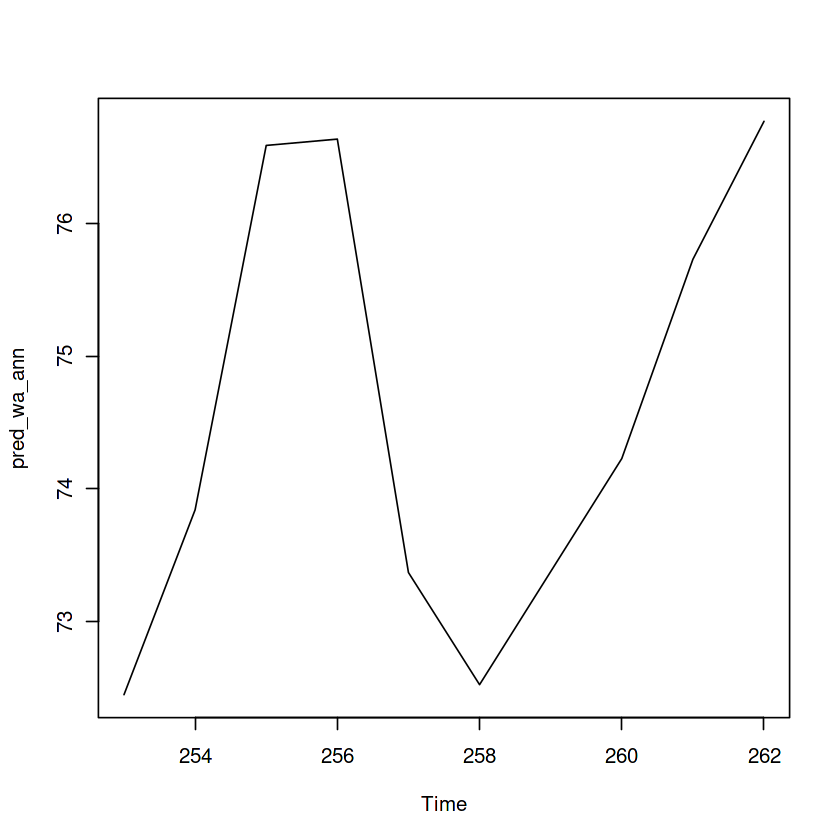

In [54]:
#fitting WARIMA+ANN hybrid model
res_wa = train - fit_wa$FinalPrediction
fit_wa_ANN=mlp(res_wa)
pred_wa_ANN = forecast::forecast(fit_wa_ANN, h=length(test))
pred_wa_ann=fit_wa$Finalforecast+pred_wa_ANN$mean
a16<-forecast::accuracy(pred_wa_ann, test);a16
plot(pred_wa_ann)

smape(test,pred_wa_ann)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-1.238034,2.231084,1.88255,-1.689368,2.548912,0.1906178,2.02284


[1] 0.02510944

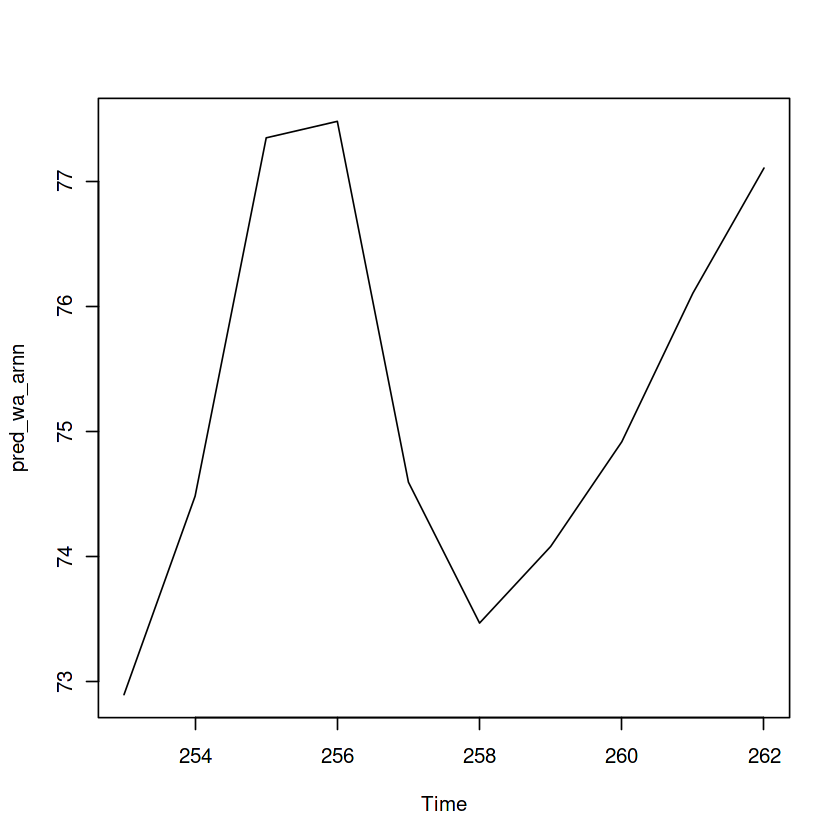

In [55]:
#fitting WARIMA + ARNN hybrid model
fit_wa_ARNN = nnetar(res_wa)
pred_wa_ARNN = forecast::forecast(fit_wa_ARNN, h=length(test))
pred_wa_arnn=fit_wa$Finalforecast+pred_wa_ARNN$mean
a17<-forecast::accuracy(pred_wa_arnn, test);a17
plot(pred_wa_arnn)

smape(test,pred_wa_arnn)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.7232815,1.364444,1.099209,0.9612591,1.478898,0.3631893,1.135019


[1] 0.01491962

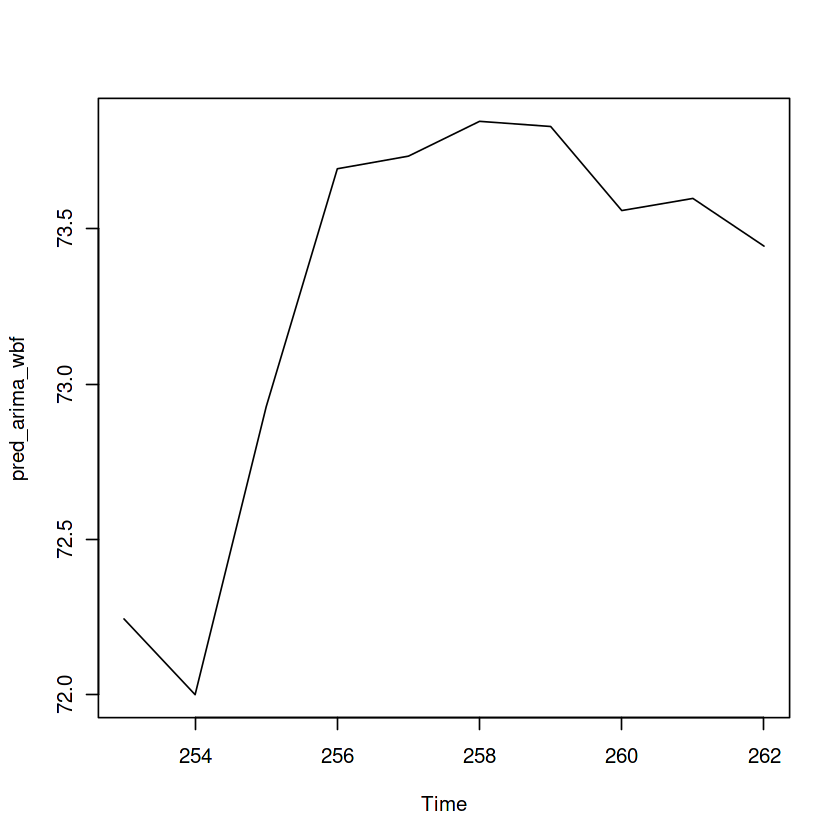

In [56]:
#fitting ARIMA + WARIMA hybrid model
fit_res_wbf=WaveletFittingarma(fitARIMA$residuals, Waveletlevels = floor(log(length(train))), boundary = 'periodic', FastFlag = TRUE, MaxARParam = 5, MaxMAParam = 5, NForecast = length(test))

pred_arima_wbf=predARIMA$mean+fit_res_wbf$Finalforecast
a18<-forecast::accuracy(pred_arima_wbf, test);a18
plot(pred_arima_wbf)

smape(test,pred_arima_wbf)

=-=-=-=-= Iteration 0 Wed Dec 22 10:21:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Wed Dec 22 10:21:17 2021 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Dec 22 10:21:19 2021 =-=-=-=-=
=-=-=-=-= Iteration 2700 Wed Dec 22 10:21:20 2021 =-=-=-=-=
=-=-=-=-= Iteration 3600 Wed Dec 22 10:21:22 2021 =-=-=-=-=
=-=-=-=-= Iteration 4500 Wed Dec 22 10:21:23 2021 =-=-=-=-=
=-=-=-=-= Iteration 5400 Wed Dec 22 10:21:25 2021 =-=-=-=-=
=-=-=-=-= Iteration 6300 Wed Dec 22 10:21:27 2021 =-=-=-=-=
=-=-=-=-= Iteration 7200 Wed Dec 22 10:21:28 2021 =-=-=-=-=
=-=-=-=-= Iteration 8100 Wed Dec 22 10:21:30 2021 =-=-=-=-=


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,14.56487,16.28899,14.56487,19.7286,19.7286,0.6861246,14.96713


[1] 0.225692

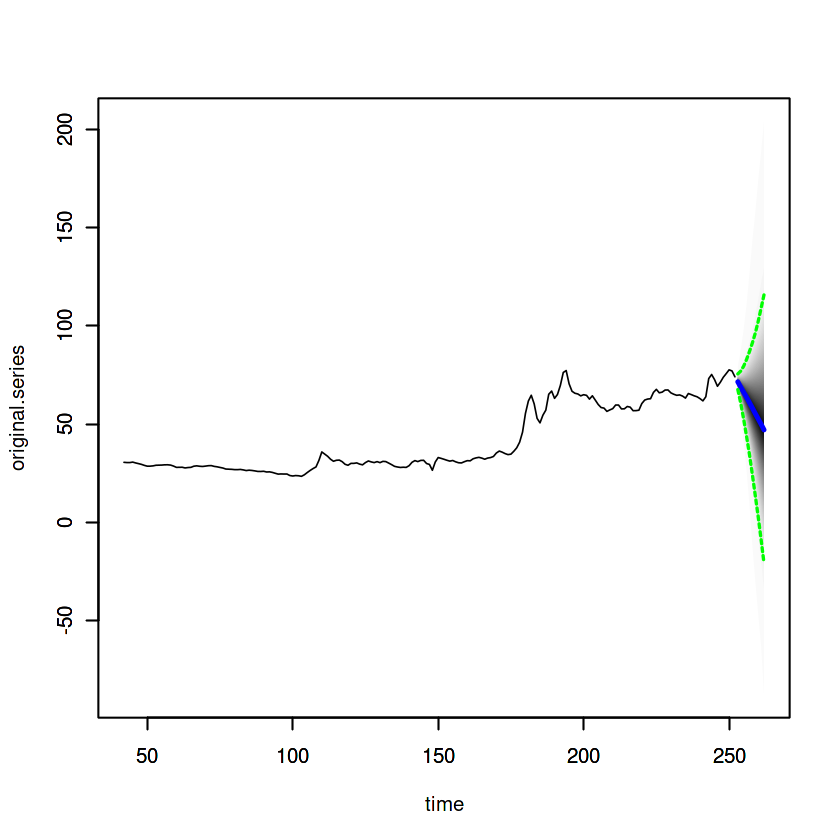

In [57]:
#fitting BSTS model -- Advanced
ss <- AddLocalLinearTrend(list(), train)
fit_bsts=bsts(train,state.specification = ss, niter = 9000)
predBSTS <- predict(fit_bsts, horizon = length(test))
plot(predBSTS, plot.original = 211)

burn <- SuggestBurn(0.1, fit_bsts)
fitted_bsts=as.numeric(-colMeans(fit_bsts$one.step.prediction.errors[-(1:burn),])+train)

a19<-forecast::accuracy(predBSTS$mean, test);a19
smape(test,predBSTS$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.03962,0.9157806,0.62046,-0.0687258,0.837339,0.2065667,0.8393912


[1] 0.008375293

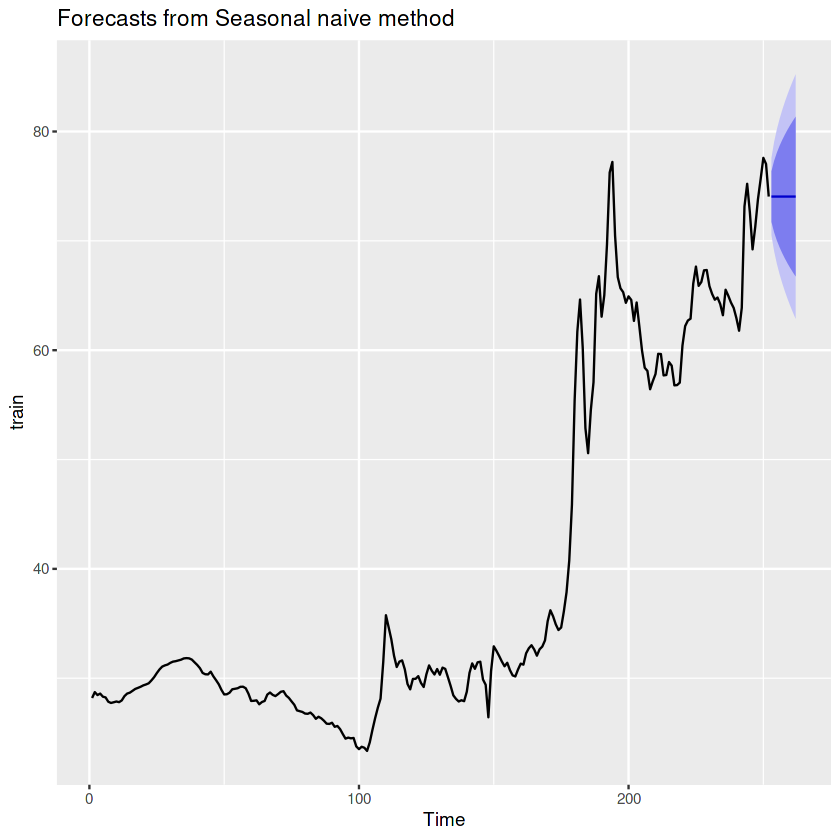

In [58]:
#Snaive - ARIMA(0,0,0)(0,1,0)m  --  Classical
fit_snaive = snaive(train, h=length(test))
autoplot(fit_snaive)

a20<-forecast::accuracy(fit_snaive$mean, test);a20
smape(test,fit_snaive$mean)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.03991827,0.9157936,0.6205197,-0.06912888,0.8374229,0.2065667,0.8394045


[1] 0.008376099

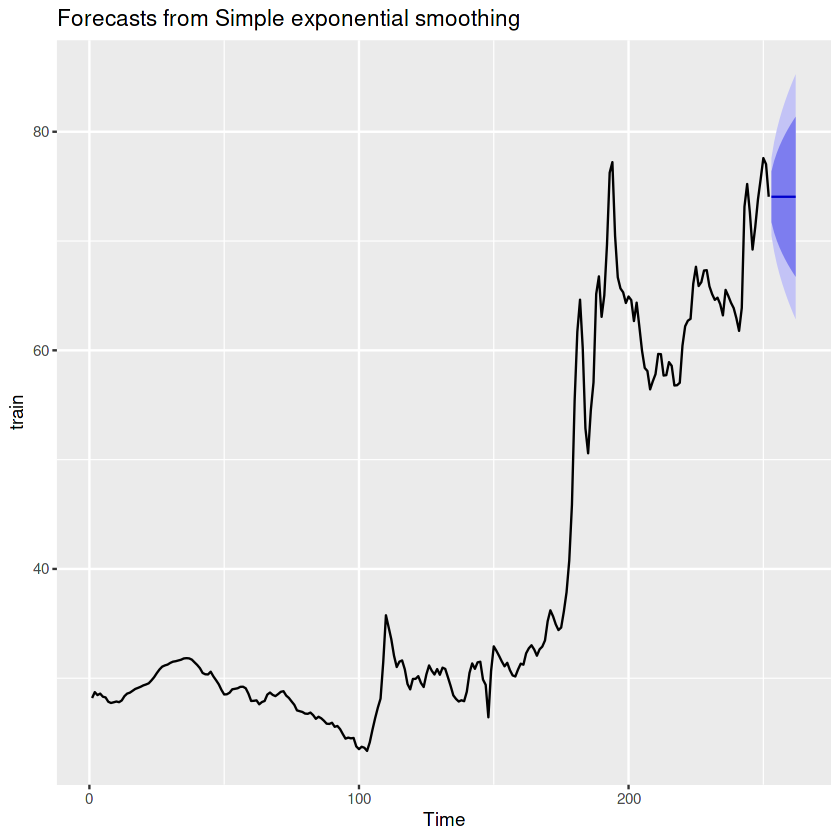

In [59]:
#Ses --  Simple exponential smoothing
fit_ses = ses(train, h=length(test))
autoplot(fit_ses)

a21<-forecast::accuracy(fit_ses$mean, test);a21
smape(test,fit_ses$mean)

**Catboost**

In [60]:
# Importing Catboost
failed_loading_catboost = FALSE
tryCatch(library(catboost), error = function(err) {failed_loading_catboost<<-TRUE})

In [61]:
if(lag == 0){
    lag = 1
}

In [62]:
# Initializing Catboost parameters
embedded_series <- NULL
series_means <- NULL
mean <- mean(train)
train_cat <- train/mean
series_means <- c(series_means, mean)
embedded <- embed(train_cat, lag + 1)
embedded_series <- rbind(embedded_series, embedded)

final_lags <- NULL
current_series_final_lags <- t(as.matrix(rev(tail(train_cat, lag))))
final_lags_cat <- rbind(final_lags, current_series_final_lags)

In [63]:
# Fitting the CatBoost model
if (failed_loading_catboost) stop("Error when loading catboost, cannot run global model based on catboost")
    train_pool <- catboost.load_pool(data = as.matrix(embedded_series[,-1]),label=as.matrix(embedded_series[,1]))
    model_cat <- catboost.train(train_pool)

Training catboost with default parameters! See help(catboost.train).



Learning rate set to 0.030495
0:	learn: 0.3986539	total: 51ms	remaining: 50.9s
1:	learn: 0.3877575	total: 51.9ms	remaining: 25.9s
2:	learn: 0.3772488	total: 52.7ms	remaining: 17.5s
3:	learn: 0.3678484	total: 53.5ms	remaining: 13.3s
4:	learn: 0.3578624	total: 54.4ms	remaining: 10.8s
5:	learn: 0.3493294	total: 55ms	remaining: 9.11s
6:	learn: 0.3397662	total: 55.7ms	remaining: 7.9s
7:	learn: 0.3307926	total: 56.3ms	remaining: 6.99s
8:	learn: 0.3219785	total: 57.1ms	remaining: 6.29s
9:	learn: 0.3133759	total: 57.7ms	remaining: 5.72s
10:	learn: 0.3051288	total: 58.4ms	remaining: 5.25s
11:	learn: 0.2971166	total: 59.1ms	remaining: 4.87s
12:	learn: 0.2895257	total: 59.5ms	remaining: 4.52s
13:	learn: 0.2819243	total: 60.2ms	remaining: 4.24s
14:	learn: 0.2745015	total: 60.8ms	remaining: 3.99s
15:	learn: 0.2672660	total: 61.3ms	remaining: 3.77s
16:	learn: 0.2603453	total: 61.9ms	remaining: 3.58s
17:	learn: 0.2537639	total: 62.5ms	remaining: 3.41s
18:	learn: 0.2472472	total: 63ms	remaining: 3.25s

In [64]:
# Predictions in Catboost model
predictions <- NULL
for (i in 1:length(test)){
    catboost_final_lags <- catboost.load_pool(final_lags_cat)
    new_predictions <- catboost.predict(model_cat, catboost_final_lags)
    predictions <- cbind(predictions, new_predictions)
    if(i < length(test)){
      final_lags_cat <- final_lags_cat[-lag]
      final_lags_cat <- cbind(new_predictions, final_lags_cat)
      colnames(final_lags_cat)[1:lag] <- paste("Lag", 1:lag, sep="")
      final_lags_cat <- as.data.frame(final_lags_cat)
    }
  }

pred = list()
for(i in 1:length(test)){
    pred[i] <- predictions[i]
}
pred = as.numeric(pred)
predictions_cat <- pred * as.vector(series_means)

In [65]:
# Catboots Accuracy
smape(test,predictions_cat)
a23<-forecast::accuracy(predictions_cat,test);a23

[1] 0.03055492

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,1.003415,2.739933,2.219659,1.361052,3.006703,0.3483242,2.191014


**Pool regression**

In [66]:
# Initializing Pool regression paramters
final_lags_poolreg <- final_lags
current_series_final_lags <- t(as.matrix(rev(tail(train_cat, lag))))
final_lags_poolreg <- rbind(final_lags_poolreg, current_series_final_lags)
colnames(final_lags_poolreg)[1:lag] <- paste("Lag", 1:lag, sep="")

embedded_series <- as.data.frame(embedded_series)
colnames(embedded_series)[1] <- "y"
colnames(embedded_series)[2:(lag + 1)] <- paste("Lag", 1:lag, sep = "")

formula <- "y ~ "
  for(predictor in 2:ncol(embedded_series)){
    if(predictor != ncol(embedded_series)){
      formula <- paste0(formula, colnames(embedded_series)[predictor], " + ")
    }else{
      formula <- paste0(formula, colnames(embedded_series)[predictor])
    }
  }

formula <- paste(formula, "+ 0", sep="")
formula <- as.formula(formula)

In [67]:
# Fitting Pool Regression model
model_pool_reg <- glm(formula = formula, data = embedded_series)

In [68]:
# Predictions in Pool regression model
predictions <- NULL
for (i in 1:length(test)){
    new_predictions <- predict.glm(object = model_pool_reg, newdata = as.data.frame(final_lags_poolreg))
    predictions <- cbind(predictions, new_predictions)
    if(i < length(test)){
      final_lags_poolreg <- final_lags_poolreg[-lag]
      final_lags_poolreg <- cbind(new_predictions, final_lags_poolreg)
      colnames(final_lags_poolreg)[1:lag] <- paste("Lag", 1:lag, sep="")
      final_lags_poolreg <- as.data.frame(final_lags_poolreg)
    }
  }

pred = list()
for(i in 1:length(test)){
    pred[i] <- predictions[i]
}
pred <- as.numeric(pred)
predictions_poolreg <- pred * as.vector(series_means)

In [69]:
# Pool regression model accuracy
smape(test,predictions_poolreg)
a24 <- forecast::accuracy(test,predictions_poolreg); a24

[1] 0.02012643

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.392063,1.793812,1.480017,-1.922092,2.042603


In [70]:
library(rlist)
org <- list(train,test)
t1 <- c(as.numeric(Map("+", fitted(fitARIMA), fit_res_wbf$FinalPrediction)))
hyb <- list(t1,pred_arima_wbf)
snv <- list(fitted(fit_snaive), fit_snaive$mean)

list.save(org, 'org_rs.json', type = "JSON")
list.save(hyb, 'hyb_rs.json', type = "JSON")
list.save(snv, 'snaive_rs.json', type = "JSON")

dates = list(train_dates,test_dates)
list.save(dates, 'dates_rs.json', type = "JSON")